In [462]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [463]:
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

* Drop nan values
* Scale the data
* Split the data
* Train the model
* Tune the model
* Plot the result
* Save the model

In [464]:
raw_data = pd.read_csv("./atussum_1121-reduced.csv")

In [465]:
raw_X = raw_data.iloc[:, -18:]
raw_y = raw_data.iloc[:, :-18]

In [466]:
raw_X.columns

Index(['t01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10',
       't11', 't12', 't13', 't14', 't15', 't16', 't18', 't50'],
      dtype='object')

In [467]:
raw_y.columns

Index(['TUCASEID', 'GEMETSTA', 'GTMETSTA', 'PEEDUCA', 'PEHSPNON', 'PTDTRACE',
       'TEAGE', 'TELFS', 'TEMJOT', 'TESCHENR', 'TESCHLVL', 'TESEX',
       'TESPEMPNOT', 'TRCHILDNUM', 'TRDPFTPT', 'TRERNWA', 'TRHOLIDAY',
       'TRSPFTPT', 'TRSPPRES', 'TRYHHCHILD', 'TUDIARYDAY', 'TUFNWGTP',
       'TEHRUSLT', 'TUYEAR', 'TU20FWGT'],
      dtype='object')

In [468]:
def save_best_model(col, model_name, best_model):

    if col in num_columns:
        model_path_name = "./saved_model/numerical/" + col + "_" + model_name + ".pkl"
    elif col in cat_columns:
        model_path_name = "./saved_model/categorial/" + col + "_" + model_name + ".pkl"
        
    with open(model_path_name, 'wb') as f:
        pickle.dump(best_model, f)

In [469]:
def load_best_model(col, model_name):

    if col in num_columns:
        model_path_name = "./saved_model/numerical/" + col + "_" + model_name + ".pkl"
    elif col in cat_columns:
        model_path_name = "./saved_model/categorial/" + col + "_" + model_name + ".pkl"
        
    with open(model_path_name, 'rb') as f:
        best_model = pickle.load(f)
        
    return best_model

In [470]:
def save_scaler(col, scaler):
    
    scaler_path_name = "./saved_scaler/" + col + ".pkl"
    
    with open(scaler_path_name, 'wb') as f:
        pickle.dump(scaler, f)

In [471]:
def load_scaler(col):
    
    scaler_path_name = "./saved_scaler/" + col + ".pkl"
        
    with open(scaler_path_name, 'rb') as f:
        scaler = pickle.load(f)
        
    return scaler

In [472]:
def mlpreg_search(X_train, y_train):

    mlp_model = MLPRegressor(random_state=1, max_iter=500, early_stopping=True).fit(X_train, y_train)
    parameters = {
        'learning_rate_init': [0.001, 0.05, 0.01, 0.02],
        'alpha': [0.001, 0.01, 0.05]
    }
    
    clf = RandomizedSearchCV(mlp_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [473]:
def xgbreg_search(X_train, y_train):
        
    xgb_model = XGBRegressor(nthread=24, use_label_encoder=False)
    parameters = {
        'learning_rate': [0.005, 0.01, 0.03, 0.05],
        'n_estimators': [900, 1200, 1500, 1800],
        'max_depth': [3, 5, 7]
    }
    
    # clf = GridSearchCV(xgb_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = RandomizedSearchCV(xgb_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [474]:
def lassoreg_search(X_train, y_train):

    lasso_model = Lasso(max_iter=1500)
    parameters = {
        'alpha': [0.01, 0.1, 1, 5, 10, 20, 30],
    }
    
    clf = RandomizedSearchCV(lasso_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [475]:
def ridgereg_search(X_train, y_train):

    ridge_model = Ridge(max_iter=1500)
    parameters = {
        'alpha': [0.01, 0.1, 1, 5, 10, 20, 30],
    }
    
    clf = RandomizedSearchCV(ridge_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [476]:
def randomforestreg_search(X_train, y_train):
    
    random_forest_model = RandomForestRegressor(n_jobs=-1, random_state=0)
    parameters = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [3, 5, 7, 9]
    }
    
    clf = RandomizedSearchCV(random_forest_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [477]:
def xgbcls_search(X_train, y_train):
        
    xgb_model = XGBClassifier(nthread=32, use_label_encoder=False)
    parameters = {
        'learning_rate': [0.005, 0.01, 0.03, 0.05],
        'n_estimators': [900, 1200, 1500, 1800],
        'max_depth': [3, 5, 7]
    }
    
    # clf = GridSearchCV(xgb_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = RandomizedSearchCV(xgb_model, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train), verbose=3)
    clf = clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    
    return best_estimator

In [478]:
def performance_evaluation(col_name, gt, pred):
    
    if col_name in num_columns:
        rmse = np.sqrt(mean_squared_error(gt, pred))
        mse = mean_squared_error(gt, pred)
        r2 = r2_score(gt, pred)
        return rmse, mse, r2
    elif col_name in cat_columns:
        precision = precision_score(gt, pred, average="macro")
        recall = recall_score(gt, pred, average="macro")
        f1 = f1_score(gt, pred, average="macro")
        acc = accuracy_score(gt, pred)
        return precision, recall, f1, acc

In [479]:
def change_label(col_name, y):
    
    changed_y = y.copy()
    if col_name == "TELFS":
        ## TELFS [1-2=employed -> 0, 3-4 unemployed -> 1, 5=not in labor force -> 2]
        changed_y = changed_y.replace(2, 0)
        changed_y = changed_y.replace(1, 0)
        changed_y = changed_y.replace(3, 1)
        changed_y = changed_y.replace(4, 1)
        changed_y = changed_y.replace(5, 2)
    elif col_name in ["TEMJOT", "TESCHENR", "TESCHLVL", "TESEX", "TESPEMPNOT", "TRDPFTPT"]:
        ## TEMJOT [1=Yes -> 1, 2=No -> 0]
        ## TESCHENR [1=Yes -> 1, 2=No -> 0]
        ## TESCHLVL [1=High school -> 1, 2=College or university -> 0]
        ## TESEX [1=Male -> 1, 2=Female -> 0]
        ## TESPEMPNOT [1=Employed -> 1, 2=Not employed -> 0]
        ## TRDPFTPT [1=full time -> 1, 2=part time -> 0]
        changed_y = changed_y.replace(2, 0)
    elif col_name in ["TRSPFTPT", "TRSPPRES"]:
        ## TRSPFTPT [1=full time -> 0, 2=part time -> 1, 3=hours vary -> 1]
        ## TRSPPRES [1=Spouse present -> 0, 2=Unmarried partner present -> 1, 3=No spouse or unmarried partner present -> 2]
        changed_y = changed_y.replace(1, 0)
        changed_y = changed_y.replace(2, 1)
        changed_y = changed_y.replace(3, 2)
        
    return changed_y

In [480]:
def timer(start_time=None):
    
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [481]:
#### Categorial Prediction 10
# TELFS, Tabor Force Status, [1-2=employed, 3-4 unemployed, 5=not in labor force]
# TEMJOT, in the last seven days did you have more than one job?, [1=Yes, 2=No]
# TESCHENR, are you enrolled in high school, college, or university?, [1=Yes, 2=No]
# TESCHLVL, would that be high school, college, or university?, [1=High school, 2=College or university]
# TESEX, sex, [1=Male, 2=Female]
# TESPEMPNOT, employment status of spouse or unmarried partner, [1=Employed, 2=Not employed]
# TRDPFTPT, Full time or part time employment status of respondent, [1=full time, 2=part time]
# TRHOLIDAY, Flag to indicate if diary day was a holiday, [0=No, 1=Yes] -> DROP
# TRSPFTPT, Full time or part time employment status of spouse or unmarried partner, [1=full time, 2=part time, 3=hours vary]
# TRSPPRES, Presence of the respondent's spouse or unmarried partner in the household, [1=Spouse present, 2=Unmarried partner present, 3=No spouse or unmarried partner present]

#### Numerical Prediction 5
# TEAGE, Age
# TRCHILDNUM, Number of household children < 18
# TRERNWA, Weekly earnings at main job -> DROP
# TRYHHCHILD, Age of youngest household child < 18
# TEHRUSLT, Estimate hours worked per week

In [482]:
#### Timecode Category
# 01 Personal Care Activities
# 12 Socializing, Relaxing, and Leisure
# 05 Work & Work-Related Activities
# 02 Household Activities
# 18 Traveling
# 11 Eating and Drinking

In [483]:
x_cat = ["t01", "t12", "t05", "t02", "t18", "t11"]

In [484]:
column_description = {
    "TELFS": "Tabor Force Status, [0=employed, 1=unemployed, 2=not in labor force]",
    "TEMJOT": "in the last seven days did you have more than one job?, [1=Yes, 0=No]",
    "TESCHENR": "are you enrolled in high school, college, or university?, [1=Yes, 0=No]",
    "TESCHLVL": "would that be high school, college, or university?, [1=High school, 0=College or university]",
    "TESEX": "sex, [1=Male, 0=Female]",
    "TESPEMPNOT": "employment status of spouse or unmarried partner, [1=Employed, 0=Not employed]",
    "TRDPFTPT": "Full time or part time employment status of respondent, [1=full time, 0=part time]",
    "TRSPFTPT": "Full time or part time employment status of spouse or unmarried partner, [0=full time, 1=part time, 2=hours vary]",
    "TRSPPRES": "Presence of the respondent's spouse or unmarried partner in the household, [0=Spouse present, 1=Unmarried partner present, 2=No spouse or unmarried partner present]",
    "TEAGE": "Age",
    "TRCHILDNUM": "Number of household children < 18",
    "TRYHHCHILD": "Age of youngest household child < 18",
    "TEHRUSLT": "Estimate hours worked per week"
}

In [485]:
cat_columns = ["TELFS", "TEMJOT", "TESCHENR", "TESCHLVL", \
               "TESEX", "TESPEMPNOT", "TRDPFTPT", "TRSPFTPT", \
               "TRSPPRES"]
num_columns = ["TEAGE", "TRCHILDNUM", "TRYHHCHILD", "TEHRUSLT"]

In [492]:
num_columns

['TEAGE', 'TRCHILDNUM', 'TRYHHCHILD', 'TEHRUSLT']

In [486]:
len(raw_data[raw_data["TUYEAR"] == 2011]), \
len(raw_data[raw_data["TUYEAR"] == 2013]), \
len(raw_data[raw_data["TUYEAR"] == 2015]), \
len(raw_data[raw_data["TUYEAR"] == 2017]), \
len(raw_data[raw_data["TUYEAR"] == 2019]), \
len(raw_data[raw_data["TUYEAR"] == 2021])

(12479, 11385, 10905, 10223, 9435, 9087)

### Numerical Prediction

TEAGE : Age
(42554, 6) (42554,) (20960, 6) (20960,)


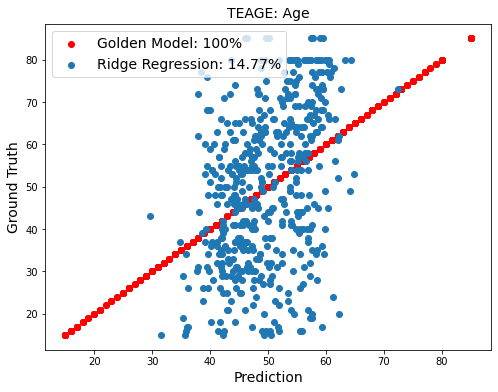

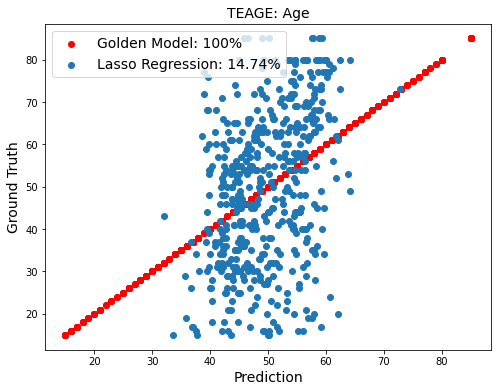

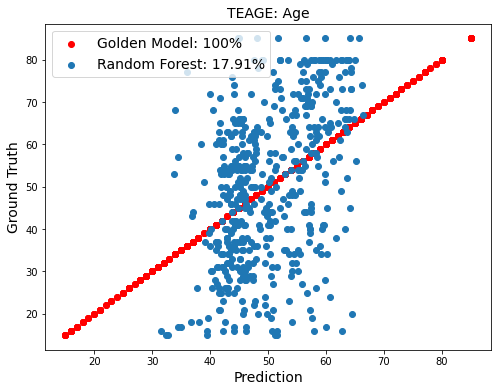

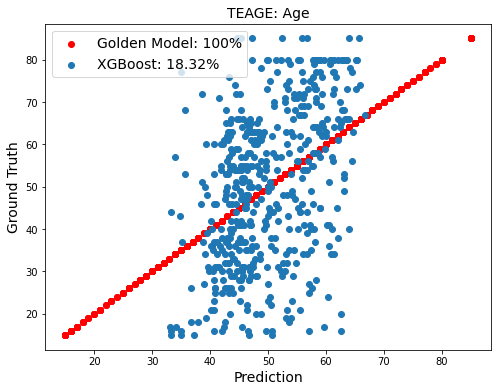

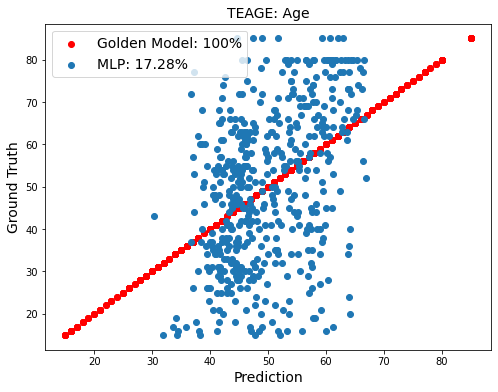

Ridge RMSE:  16.6408 , MSE:  276.9163 , R-squared:  0.1477
Lasso RMSE:  16.6435 , MSE:  277.0075 , R-squared:  0.1474
RF RMSE:  16.3316 , MSE:  266.7224 , R-squared:  0.1791
XGB RMSE:  16.2907 , MSE:  265.3853 , R-squared:  0.1832
MLP RMSE:  16.3942 , MSE:  268.7691 , R-squared:  0.1728
-------------------------------------
TRCHILDNUM : Number of household children < 18
(42554, 6) (42554,) (20960, 6) (20960,)


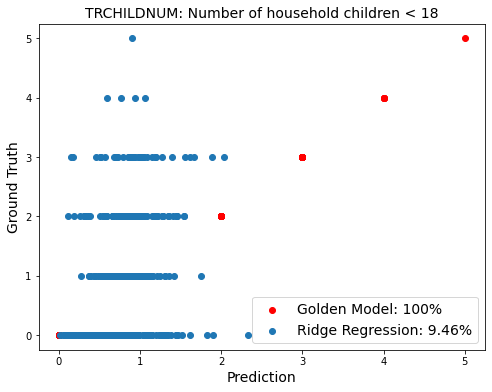

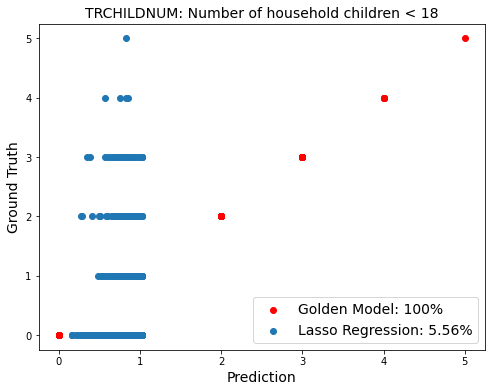

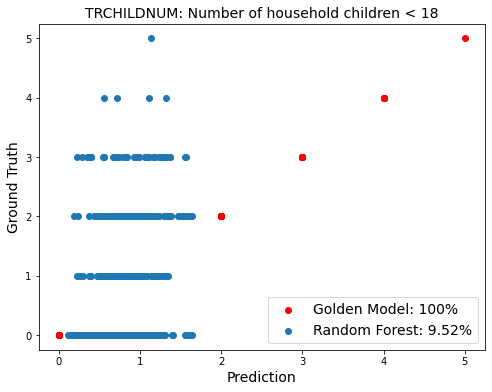

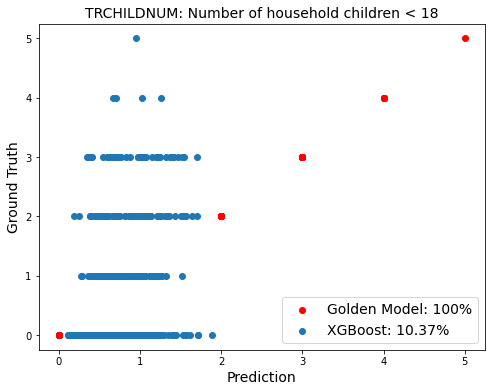

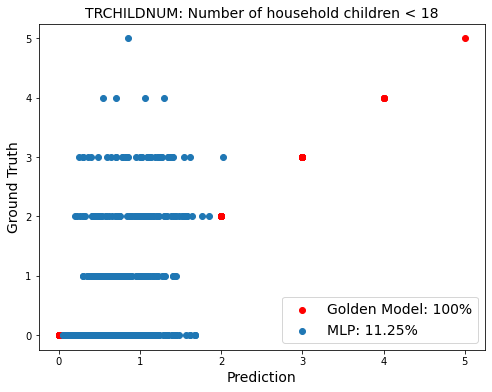

Ridge RMSE:  1.0348 , MSE:  1.0709 , R-squared:  0.0946
Lasso RMSE:  1.0569 , MSE:  1.117 , R-squared:  0.0556
RF RMSE:  1.0345 , MSE:  1.0701 , R-squared:  0.0952
XGB RMSE:  1.0296 , MSE:  1.0601 , R-squared:  0.1037
MLP RMSE:  1.0245 , MSE:  1.0496 , R-squared:  0.1125
-------------------------------------
TRYHHCHILD : Age of youngest household child < 18
(17195, 6) (17195,) (8470, 6) (8470,)


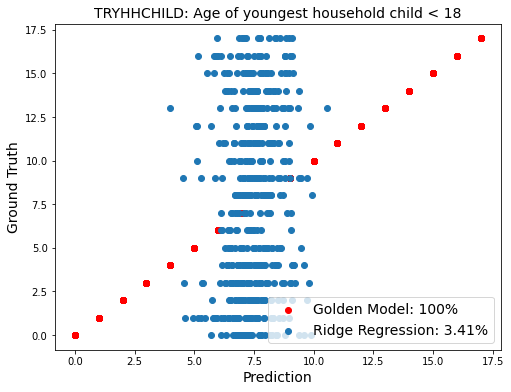

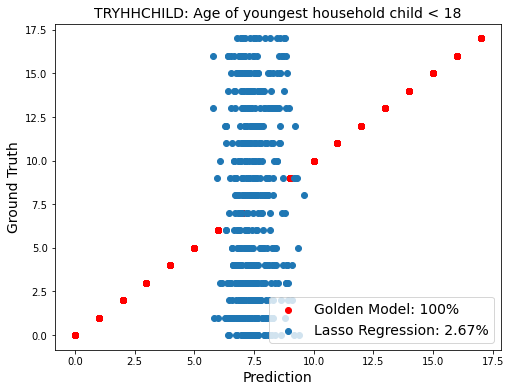

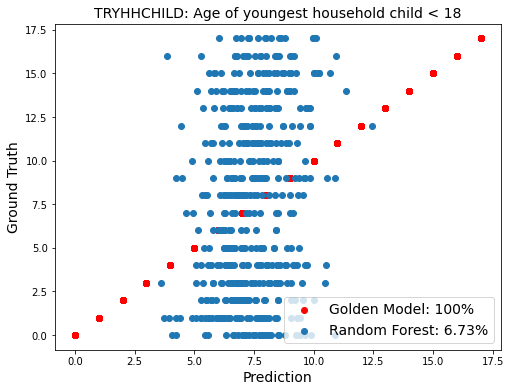

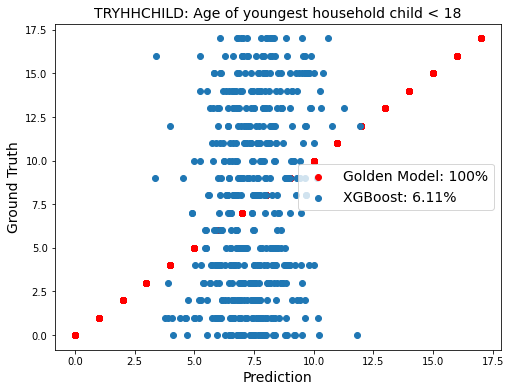

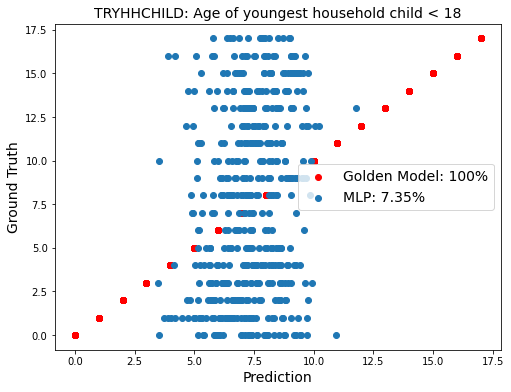

Ridge RMSE:  5.2046 , MSE:  27.0878 , R-squared:  0.0341
Lasso RMSE:  5.2243 , MSE:  27.2934 , R-squared:  0.0267
RF RMSE:  5.1141 , MSE:  26.1545 , R-squared:  0.0673
XGB RMSE:  5.1313 , MSE:  26.3301 , R-squared:  0.0611
MLP RMSE:  5.0973 , MSE:  25.9821 , R-squared:  0.0735
-------------------------------------
TEHRUSLT : Estimate hours worked per week
(24133, 6) (24133,) (11887, 6) (11887,)


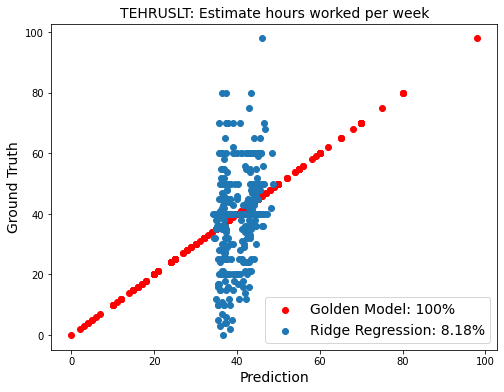

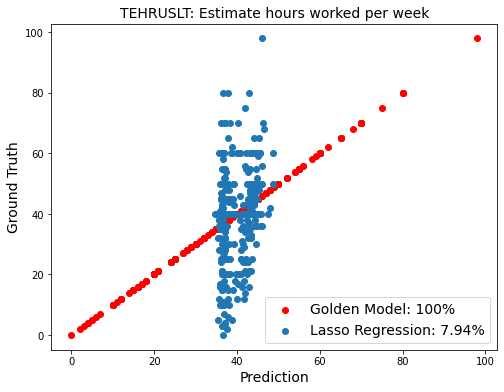

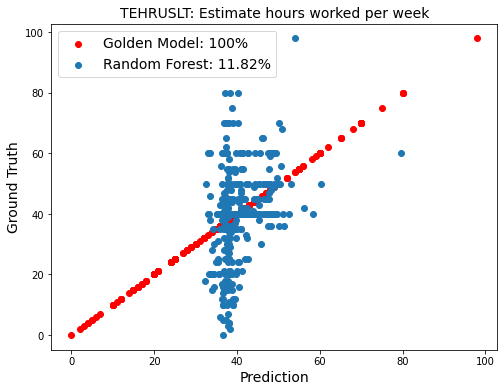

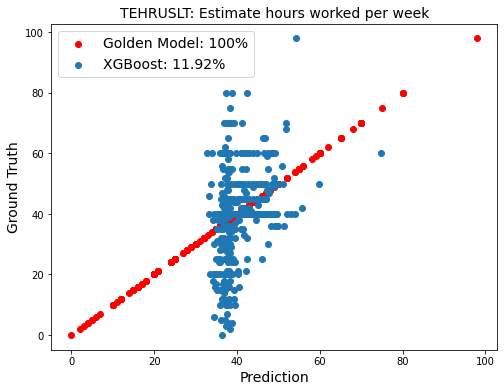

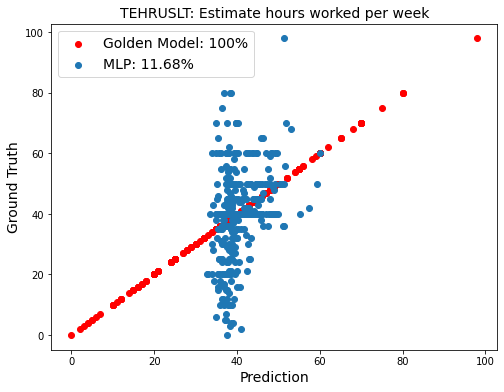

Ridge RMSE:  12.5986 , MSE:  158.7253 , R-squared:  0.0818
Lasso RMSE:  12.6149 , MSE:  159.1363 , R-squared:  0.0794
RF RMSE:  12.3466 , MSE:  152.4391 , R-squared:  0.1182
XGB RMSE:  12.3391 , MSE:  152.2544 , R-squared:  0.1192
MLP RMSE:  12.3564 , MSE:  152.6816 , R-squared:  0.1168
-------------------------------------


In [487]:
performance_results = []
for c, col_ in enumerate(num_columns):
    
    print(col_, ":", column_description[col_])
    
    ### Copy X and y ###
    X = raw_X.copy()[x_cat]
    y = raw_y.copy()
    ####################
    
    ### Drop -1 out ###
    non_nan_index = y[y[col_] >= 0].index
    X = X.iloc[non_nan_index]
    y = y[col_].iloc[non_nan_index]
    ####################
    
    ### Scale X ###
    for time_cat in X.columns:
        if os.path.exists("./saved_scaler/" + time_cat + ".pkl") == True:
            scaler = load_scaler(time_cat)
            scaled_X = scaler.transform(np.expand_dims(Ｘ[time_cat].values, axis=1))
            X[time_cat] = scaled_X
        else:
            scaler = MinMaxScaler()
            scaled_X = scaler.fit_transform(np.expand_dims(Ｘ[time_cat].values, axis=1))
            X[time_cat] = scaled_X
            save_scaler(time_cat, scaler)
    ####################
    
    ### Split Data ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    ####################
    
    ### Check Existed Model or Train Model ###
    if os.path.exists("./saved_model/numerical/" + col_ + "_lasso.pkl") == True:
        lassoreg_best = load_best_model(col_, "lasso")
    else:
        start_time = timer(None)
        lassoreg_best = lassoreg_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "lasso", lassoreg_best)
        
    if os.path.exists("./saved_model/numerical/" + col_ + "_ridge.pkl") == True:
        ridgereg_best = load_best_model(col_, "ridge")
    else:
        start_time = timer(None)
        ridgereg_best = ridgereg_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "ridge", ridgereg_best)
    
    if os.path.exists("./saved_model/numerical/" + col_ + "_rf.pkl") == True:
        rfreg_best = load_best_model(col_, "rf")
    else:
        start_time = timer(None)
        rfreg_best = randomforestreg_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "rf", rfreg_best)
        
    if os.path.exists("./saved_model/numerical/" + col_ + "_xgb.pkl") == True:
        xgbreg_best = load_best_model(col_, "xgb")
    else:
        start_time = timer(None)
        xgbreg_best = xgbreg_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "xgb", xgbreg_best)
    
    if os.path.exists("./saved_model/numerical/" + col_ + "_mlp.pkl") == True:
        mlpreg_best = load_best_model(col_, "mlp")
    else:
        start_time = timer(None)
        mlpreg_best = mlpreg_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "mlp", mlpreg_best)
    ####################
    
    ### Model Inference ###
    ridge_prediction = ridgereg_best.predict(X_test)
    lasso_prediction = lassoreg_best.predict(X_test)
    rf_prediction = rfreg_best.predict(X_test)
    xgb_prediction = xgbreg_best.predict(X_test)
    mlp_prediction = mlpreg_best.predict(X_test)
    ####################
    
    ### Plot Prediction ###
    sampled_index = np.random.choice(len(y_test), 500, replace=False)
    for model_name, pred in zip(["Ridge Regression", "Lasso Regression", "Random Forest", "XGBoost", "MLP"], [ridge_prediction, lasso_prediction, rf_prediction, xgb_prediction, mlp_prediction]):
        r2 = r2_score(y_test, pred)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test.values[sampled_index],  y_test.values[sampled_index], color="red", label="Golden Model: 100%")
        plt.scatter(pred[sampled_index], y_test.values[sampled_index], label=model_name + ": " + str(round(100 * r2, 2)) + "%")
        
        plt.legend(fontsize=14)
        plt.xlabel("Prediction", fontsize=14)
        plt.ylabel("Ground Truth", fontsize=14)
        plt.title(col_ + ": " + column_description[col_], fontsize=14)
        plt.savefig("./saved_fig/" + model_name + "_" + col_ + ".png")
        plt.show()
    ####################
    
    ### Performance Evaluation ###
    ridge_rmse, ridge_mse, ridge_r2 = performance_evaluation(col_, y_test, ridge_prediction)
    lasso_rmse, lasso_mse, lasso_r2 = performance_evaluation(col_, y_test, lasso_prediction)
    rf_rmse, rf_mse, rf_r2 = performance_evaluation(col_, y_test, rf_prediction)
    xgb_rmse, xgb_mse, xgb_r2 = performance_evaluation(col_, y_test, xgb_prediction)
    mlp_rmse, mlp_mse, mlp_r2 = performance_evaluation(col_, y_test, mlp_prediction)
    ####################
    
    print("Ridge RMSE: ", round(ridge_rmse, 4), ", MSE: ", round(ridge_mse, 4), ", R-squared: ", round(ridge_r2, 4))
    print("Lasso RMSE: ", round(lasso_rmse, 4), ", MSE: ", round(lasso_mse, 4), ", R-squared: ", round(lasso_r2, 4))
    print("RF RMSE: ", round(rf_rmse, 4), ", MSE: ", round(rf_mse, 4), ", R-squared: ", round(rf_r2, 4))
    print("XGB RMSE: ", round(xgb_rmse, 4), ", MSE: ", round(xgb_mse, 4), ", R-squared: ", round(xgb_r2, 4))
    print("MLP RMSE: ", round(mlp_rmse, 4), ", MSE: ", round(mlp_mse, 4), ", R-squared: ", round(mlp_r2, 4))
    print("-------------------------------------")
    
    perf_dict = {"Ridge_RMSE": ridge_rmse, \
                 "Ridge_MSE": ridge_mse, \
                 "Ridge_R2": ridge_r2, \
                 "Lasso_RMSE": lasso_rmse, \
                 "Lasso_MSE": lasso_mse, \
                 "Lasso_R2": lasso_r2, \
                 "RF_RMSE": rf_rmse, \
                 "RF_MSE": rf_mse, \
                 "RF_R2": rf_r2, \
                 "XGB_RMSE": xgb_rmse, \
                 "XGB_MSE": xgb_mse, \
                 "XGB_R2": xgb_r2, \
                 "MLP_RMSE": mlp_rmse, \
                 "MLP_MSE": mlp_mse, \
                 "MLP_R2": mlp_r2
                }
    
    performance_results.append(perf_dict)

In [488]:
numerical_perf = pd.DataFrame(performance_results)

In [489]:
numerical_perf.index = num_columns
numerical_perf

,Ridge_RMSE,Ridge_MSE,Ridge_R2,Lasso_RMSE,Lasso_MSE,Lasso_R2,RF_RMSE,RF_MSE,RF_R2,XGB_RMSE,XGB_MSE,XGB_R2,MLP_RMSE,MLP_MSE,MLP_R2
TEAGE,16.640804,276.916349,0.147674,16.643542,277.007485,0.147394,16.331638,266.722407,0.179050,16.290651,265.385311,0.183166,16.394178,268.769072,0.172751
TRCHILDNUM,1.034829,1.070871,0.094593,1.056860,1.116953,0.055632,1.034457,1.070102,0.095244,1.029615,1.060108,0.103694,1.024523,1.049647,0.112538
TRYHHCHILD,5.204594,27.087802,0.034064,5.224305,27.293366,0.026734,5.114144,26.154468,0.067347,5.131290,26.330132,0.061083,5.097266,25.982120,0.073492
TEHRUSLT,12.598623,158.725298,0.081807,12.614923,159.136281,0.079429,12.346623,152.439096,0.118171,12.339139,152.254353,0.119240,12.356440,152.681603,0.116768


In [490]:
numerical_perf.to_csv("./performance_table/numerical.csv", index=True)

### Categorical Classification

In [454]:
"""
for c, col_ in enumerate(cat_columns):

    print(col_, ":", column_description[col_])
    
    ### Copy X and y ###
    X = raw_X.copy()
    y = raw_y.copy()
    ####################
    
    ### Drop -1 out ###
    non_nan_index = y[y[col_] != -1].index
    X = X.iloc[non_nan_index]
    y = y[col_].iloc[non_nan_index]
    ####################
    
    ### Change Label ###
    y = change_label(col_, y)
    ####################
    
    ### Scale X ###
    for time_cat in X.columns:
        if os.path.exists("./saved_scaler/" + time_cat + ".pkl") == True:
            scaler = load_scaler(time_cat)
            scaled_X = scaler.transform(np.expand_dims(Ｘ[time_cat].values, axis=1))
            X[time_cat] = scaled_X
        else:
            scaler = MinMaxScaler()
            scaled_X = scaler.fit_transform(np.expand_dims(Ｘ[time_cat].values, axis=1))
            X[time_cat] = scaled_X
            save_scaler(time_cat, scaler)
    ####################
    
    ### Split Data ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    ####################
    
   
    ### Check Existed Model or Train Model ###
    if os.path.exists("./saved_model/categorical/" + col_ + "_xgb.pkl") == True:
        xgbcls_best = load_best_model(col_, "xgb")
    else:
        start_time = timer(None)
        xgbcls_best = xgbcls_search(X_train, y_train)
        timer(start_time)
        save_best_model(col_, "xgb", xgbcls_best)
    
    ### Model Inference ###
    # lg_prediction = lg.predict(X_test)
    # rf_prediction = rf.predict(X_test)
    xgb_predicton = xgbcls_best.predict(X_test)
    ####################
    
    ### Performance Evaluation ###
    # lg_conf_mat = confusion_matrix(y_test, lg_prediction)
    # rf_conf_mat = confusion_matrix(y_test, rf_prediction)
    xgb_conf_mat = confusion_matrix(y_test, xgb_predicton)
    ####################
    
    print("Logistic Regression")
    precision, recall, f1, acc = performance_evaluation(col_, y_test, lg_prediction)
    print('Precision:   %.3f' % precision)
    print('Recall:      %.3f' % recall)
    print('F1-Score:    %.3f' % f1)
    print('Accuracy:    %.3f' % acc)
    print(lg_conf_mat)
    
    print("Random Forest")
    precision, recall, f1, acc = performance_evaluation(col_, y_test, xgb_predicton)
    print('Precision:   %.3f' % precision)
    print('Recall:      %.3f' % recall)
    print('F1-Score:    %.3f' % f1)
    print('Accuracy:    %.3f' % acc)
    print(rf_conf_mat)
    
    print("XGBoost")
    precision, recall, f1, acc = performance_evaluation(col_, y_test, xgb_predicton)
    print('Precision:   %.3f' % precision)
    print('Recall:      %.3f' % recall)
    print('F1-Score:    %.3f' % f1)
    print('Accuracy:    %.3f' % acc)
    print(xgb_conf_mat)
    
    print("-------------------------------------")
"""

'\nfor c, col_ in enumerate(cat_columns):\n\n    print(col_, ":", column_description[col_])\n    \n    ### Copy X and y ###\n    X = raw_X.copy()\n    y = raw_y.copy()\n    ####################\n    \n    ### Drop -1 out ###\n    non_nan_index = y[y[col_] != -1].index\n    X = X.iloc[non_nan_index]\n    y = y[col_].iloc[non_nan_index]\n    ####################\n    \n    ### Change Label ###\n    y = change_label(col_, y)\n    ####################\n    \n    ### Scale X ###\n    for time_cat in X.columns:\n        if os.path.exists("./saved_scaler/" + time_cat + ".pkl") == True:\n            scaler = load_scaler(time_cat)\n            scaled_X = scaler.transform(np.expand_dims(Ｘ[time_cat].values, axis=1))\n            X[time_cat] = scaled_X\n        else:\n            scaler = MinMaxScaler()\n            scaled_X = scaler.fit_transform(np.expand_dims(Ｘ[time_cat].values, axis=1))\n            X[time_cat] = scaled_X\n            save_scaler(time_cat, scaler)\n    ####################\n  